A while ago (in december) I had a meeting with stephen, these were some points raised
1. (done) Better reject high spurious center of mass values. The discrimination criterion should be based on a minimum number
of significant bins for the dprime based on a chance cutout
2. Do most of the analysis should on cell-probe pairs (use id_probe in DF)
3. are contextual effects independent of  probe?? if for one probe there are contextual effects, is there expected that
they also exist for other probes?
4 for the region comparisons, do them independently for each transition pair, as pooling across all of them might be
averaging out the effects, when there is no significant contextual effects.
5. conversely, for comparison of the effects of context transitions, further discriminate based on region
6. For a probe, display differences between context with a node-edge graph.


In [1]:
import itertools as itt
from pathlib import Path
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, fixed

import src.visualization.fancy_plots as fplt
from src.data.cache import set_name
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
import src.data.dPCA as cdPCA
from src.data.load import load
from src.metrics.dprime import flip_dprimes
from src.metrics.consolidated_dprimes import single_cell_dprimes, _significance

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-02-26 174956.log


In [39]:


plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)

In [40]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

In [41]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
rawDF = jl.load(Path('../data/consolidated_summary_DF_v2/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

ff_mult_corr = rawDF.mult_comp_corr == 'full'
ff_mean_signif = rawDF.mean_signif_type == 'zeros'

print(rawDF.columns)
DF = rawDF.loc[ff_mean_signif & ff_mult_corr,:]
DF['id'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id', 'probe']].agg('_'.join, axis=1)

DF = DF.drop(columns=['mult_comp_corr', 'mean_signif_type', 'cellid', 'siteid'])

print('duplicated columns?: ', any(DF.duplicated()))
print(DF.head(10))

Index(['cellid', 'context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
       'mean_signif_type', 'stim_type', 'analysis', 'siteid', 'region'],
      dtype='object')
duplicated columns?:  False
  context_pair probe    value                       metric     stim_type  \
0          0_1     1        0  significant_abs_mass_center  permutations   
1          0_1     1        0  significant_abs_mass_center  permutations   
2          0_1     1  665.901  significant_abs_mass_center  permutations   
3          0_1     1        0  significant_abs_mass_center  permutations   
4          0_1     1        0  significant_abs_mass_center  permutations   
5          0_1     1        0  significant_abs_mass_center  permutations   
6          0_1     1  485.302  significant_abs_mass_center  permutations   
7          0_1     1        0  significant_abs_mass_center  permutations   
8          0_1     1  424.489  significant_abs_mass_center  permutations   
9          0_1     1        0  signifi

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


## parameter space scaterplots
### for context and probe means

False


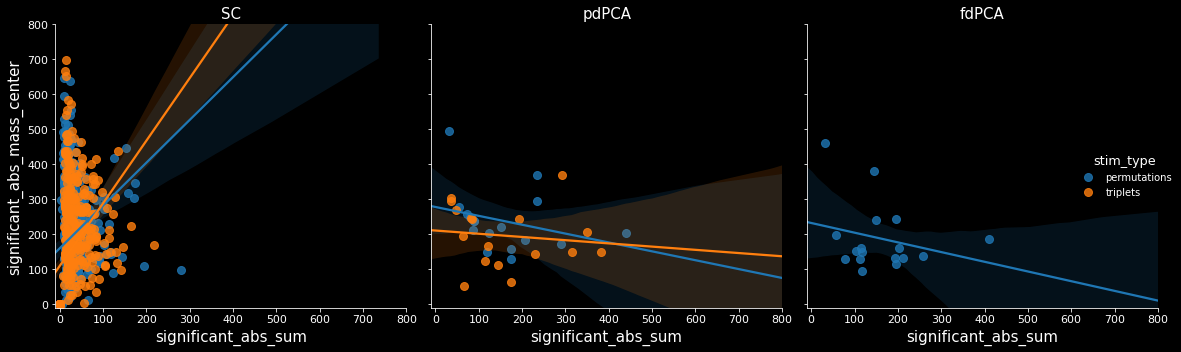

In [42]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
good_cols = [col for col in DF.columns if col not in ['value', 'id_probe', 'probe', 'context_pair']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb,:]
print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot, col='analysis', hue='stim_type',
               col_order=['SC', 'pdPCA', 'fdPCA'],sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,800)
ax.set_ylim(-10,800)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")



### same as before but for id_probes

False


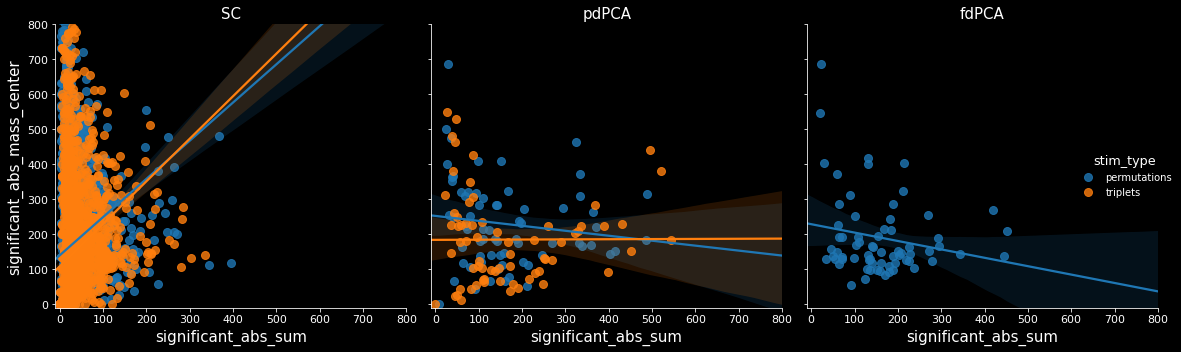

In [45]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe != 'mean'
good_cols = [col for col in DF.columns if col not in ['value', 'probe', 'context_pair', 'id']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb,:]
print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot, col='analysis', hue='stim_type',
               col_order=['SC', 'pdPCA', 'fdPCA'],sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,800)
ax.set_ylim(-10,800)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

It  looks similar to previous results, however the dimensionality reduction approaches are quite the lackluster when
comparing with the mean policy for the mean signficance. Not much to do here. perhaps see the raw dprime traces
of some of the outliers

In [27]:
# get some outlierse for SC and dPCA with low integral and high center of mass

ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
ff_analysis = DF.analysis.isin(['SC', 'pdPCA', 'fdPCA'])
ff_stim = DF.stim_type == 'permutations'


goodcols = [col for col in DF.columns if col not in ['value', 'metric', 'id_probe']]
filtered = DF.loc[ff_ctx & ff_prb & ff_analysis & ff_stim,:]
# print(any(filtered.duplicated()))
pivoted = filtered.pivot_table(index=goodcols, columns='metric', values='value', aggfunc='first').reset_index()
sorted = pivoted.sort_values(['significant_abs_mass_center', 'significant_abs_sum'], axis=0, ascending=[0,1])

print(sorted.head(10))

metric context_pair probe     stim_type analysis region            id  \
332            mean  mean  permutations       SC    PEG  AMT030a-09-4   
328            mean  mean  permutations       SC    PEG  AMT030a-03-2   
248            mean  mean  permutations       SC     A1  ley075b-12-1   
385            mean  mean  permutations       SC    PEG  CRD011c-30-3   
281            mean  mean  permutations       SC    PEG  AMT028b-04-1   
46             mean  mean  permutations       SC     A1  CRD002a-11-1   
256            mean  mean  permutations       SC    PEG  AMT026a-04-4   
74             mean  mean  permutations       SC     A1  CRD002a-42-4   
458            mean  mean  permutations    pdPCA     A1       ley075b   
381            mean  mean  permutations       SC    PEG  CRD011c-17-1   

metric  significant_abs_mass_center  significant_abs_sum  
332                      647.493786            10.247940  
328                      639.097528            24.014888  
248                

there are plenty of culprits for single cell, and a couple for dPCA:
* dPCA, ley075b
* dPCA, CRD012b
* SC, AMT030a-09-4
* SC, AMT030a-03-2

It is worth plotting the raw dprime traces and perhaps thinking a new significance correction... at least the function
already exists and should be easy to exted.


































